Problem Statement:

Given a dataset of 426K used cars, identify the key factors that influence the price of a used car. Provide actionable recommendations to a used car dealership on what consumers value in a used car to help them make informed decisions about their inventory and pricing strategies.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
# Load the dataset into a pandas dataframe:
cars = pd.read_csv('/Users/aalladin/Documents/usedCarPredict/data/vehicles.csv', index_col = 0)

# Display the first few rows of the dataframe to see whats up. Lot of data quality issues:
print(cars.head())

                            region  price  year manufacturer model condition  \
id                                                                             
7222695916                prescott   6000   NaN          NaN   NaN       NaN   
7218891961            fayetteville  11900   NaN          NaN   NaN       NaN   
7221797935            florida keys  21000   NaN          NaN   NaN       NaN   
7222270760  worcester / central MA   1500   NaN          NaN   NaN       NaN   
7210384030              greensboro   4900   NaN          NaN   NaN       NaN   

           cylinders fuel  odometer title_status transmission  VIN drive size  \
id                                                                              
7222695916       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7218891961       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7221797935       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7222270760       NaN  NaN       Na

In [3]:
cars.info() # getting some information of the dataframe schema:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426880 entries, 7222695916 to 7301591129
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  VIN           265838 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(14)

In [4]:
# identify missing by data by attribute both by count and percent:
missing_data = cars.isnull().sum()
missing_percent = cars.isnull().sum() * 100 / len(cars)
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percent': missing_percent})

#sort:
missing_info_sorted = missing_info.sort_values(by='Missing Count', ascending=False)
print(missing_info_sorted)

              Missing Count  Missing Percent
size                 306361        71.767476
cylinders            177678        41.622470
condition            174104        40.785232
VIN                  161042        37.725356
drive                130567        30.586347
paint_color          130203        30.501078
type                  92858        21.752717
manufacturer          17646         4.133714
title_status           8242         1.930753
model                  5277         1.236179
odometer               4400         1.030735
fuel                   3013         0.705819
transmission           2556         0.598763
year                   1205         0.282281
region                    0         0.000000
price                     0         0.000000
state                     0         0.000000


In [5]:
# Let's set a threshold for the maximum acceptable percentage of missing values: 
# Columns with a higher percentage of missing values than this threshold can be dropped:

threshold = 20
cols_to_drop = missing_info[missing_info['Missing Percent'] > threshold].index
cars_cleaned = cars.drop(columns=cols_to_drop) # creating a new dataframe with clean data:

In [6]:
# For columns with missing values below the threshold we will impute the missing values:

# For numerical columns I am using mean:
for col in cars_cleaned.select_dtypes(include=['int', 'float']).columns:
    cars_cleaned[col].fillna(cars_cleaned[col].mean(), inplace=True)

# For categorical columns I am using mode:
for col in cars_cleaned.select_dtypes(include=['object']).columns:
    cars_cleaned[col].fillna(cars_cleaned[col].mode()[0], inplace=True)

In [7]:
#Removing outliers that are more than 3 standard deviations from the mean:

numeric_cols = cars_cleaned.select_dtypes(include=['int', 'float']).columns

for col in numeric_cols:
    mean = cars_cleaned[col].mean()
    std = cars_cleaned[col].std()
    cutoff = std * 3
    lower, upper = mean - cutoff, mean + cutoff
    cars_cleaned = cars_cleaned[(cars_cleaned[col] >= lower) & (cars_cleaned[col] <= upper)]

In [8]:
# Dropping irrelevant columns as they are not needed for my evaluation and recommendation:

columns_to_drop = ['title_status', 'region', 'fuel']

# Drop the columns

cars_cleaned = cars_cleaned.drop(columns=columns_to_drop)

In [9]:
#remove duplicate rows:

cars_cleaned = cars_cleaned.drop_duplicates()

In [10]:
# Now for some feature engineering as it can be important to the car dealers

# Calculate the age of the car at the time of sale
cars_cleaned['age'] = 2023 - cars_cleaned['year']

# Create a new feature 'warranty_at_sale'
cars_cleaned['warranty_at_sale'] = cars_cleaned['age'].apply(lambda x: 1 if x < 5 else 0)

In [11]:
# Remove rows with price less than or equal to zero:

cars_cleaned = cars_cleaned[cars_cleaned['price'] > 0]

# Then apply the log transformation:

cars_cleaned['log_price'] = np.log(cars_cleaned['price'])
cars_cleaned = cars_cleaned.drop(columns=['price'])

In [12]:
# Standardize numerical variables so that they're on the same scale:

scaler = StandardScaler()

# List of numerical columns

num_cols = ['odometer', 'age']
cars_cleaned[num_cols] = scaler.fit_transform(cars_cleaned[num_cols])

In [13]:
# Encoding to convert categorical variables into numerical form. 
# BTW, this increased the dimensionality significantly making modeling a bit unrly.

cars_cleaned = pd.get_dummies(cars_cleaned)

In [14]:
# I am taking a  fraction of my data to sample (10%):
sample_fraction = 0.1

# Using the sample method on my pandas DataFrame to create a smaller DataFrame
cars_sample = cars_cleaned.sample(frac=sample_fraction, random_state=42)

# Then split the sampled data
X = cars_sample.drop(columns='log_price')
y = cars_sample['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_36153/3375102935.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cars.corr(), annot=True, cmap='coolwarm')


<Axes: >

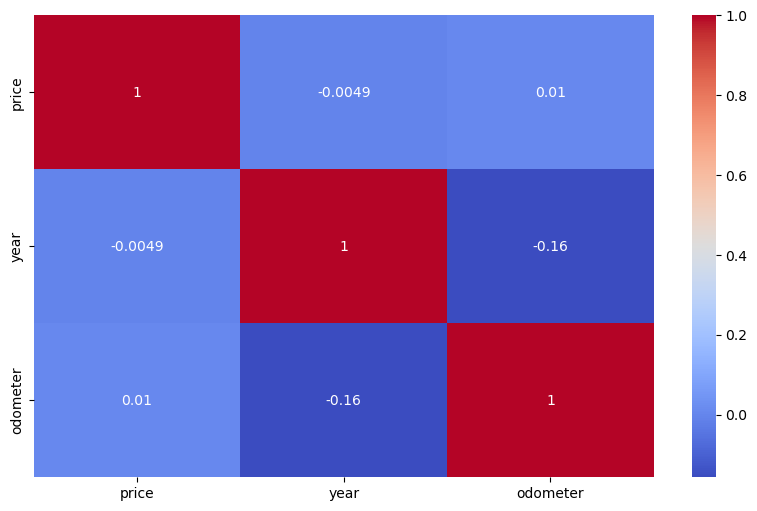

In [15]:
# Visualizing Correlations:
# A heatmap of correlations identifying variables that are closely related to each other:

plt.figure(figsize=(10,6))
sns.heatmap(cars.corr(), annot=True, cmap='coolwarm')

Using sklearn library we will build and cross-validate several regression models using Ridge Regression, and Lasso Regression. In the steps below, 'cross_val_score' performs cross-validation by splitting the training data into several subsets (controlled by the 'cv' argument), training the model on some of these subsets, and evaluating it on the remaining ones. This process is repeated several times to get a more robust estimate of the model's performance.

In [16]:
# Standardize numerical variables to standardize (mean 0, standard deviation 1) 
# the numerical features in the training and test sets. 
# This is important because different scales of features can impact some machine learning algorithms: 

scaler = StandardScaler()


In [17]:
# Assuming 'num_cols' is a list of numerical columns: 

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [18]:
# Modeling

# Defining the models
models = {'Ridge': Ridge(),
          'Lasso': Lasso()}


In [19]:
# Performing cross-validation and print results
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    print(f'{model_name} Cross-validation MSE: {-np.mean(cv_scores)}')

Ridge Cross-validation MSE: 0.8809161055896467
Lasso Cross-validation MSE: 1.1149673947822523


In [20]:
# Grid Search for Ridge and Lasso Regression
parameters = {'alpha': [1e-3, 1e-2, 1, 5, 10]}

ridge_regressor = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train, y_train)

lasso_regressor = GridSearchCV(Lasso(), parameters, scoring='neg_mean_squared_error', cv=3)
lasso_regressor.fit(X_train, y_train)

print(f"Best parameters for Ridge Regression: {ridge_regressor.best_params_}")
print(f"Best score for Ridge Regression: {np.sqrt(-ridge_regressor.best_score_)}")

print(f"Best parameters for Lasso Regression: {lasso_regressor.best_params_}")
print(f"Best score for Lasso Regression: {np.sqrt(-lasso_regressor.best_score_)}")

Best parameters for Ridge Regression: {'alpha': 5}
Best score for Ridge Regression: 0.9373022369530796
Best parameters for Lasso Regression: {'alpha': 0.001}
Best score for Lasso Regression: 0.9687142520031649


In [23]:
# Choose the best model based on the score
if ridge_regressor.best_score_ > lasso_regressor.best_score_:
    best_model = Ridge(alpha=ridge_regressor.best_params_['alpha'])
else:
    best_model = Lasso(alpha=lasso_regressor.best_params_['alpha'])

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, predictions)

print(f"MSE of best model on test set: {mse}")

MSE of best model on test set: 0.8017163061027401
